In [50]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy
import numbers
from sklearn.decomposition import PCA
import sklearn.cluster

In [2]:
data_location = 'data'
outlooks, pph, reports = read_datasets(data_location, 'labelled')

reading outlooks
reading pph
reading storm reports


# Preprocessing

In [29]:
category_dict = {
    'NONE' : -1,
    'TSTM': 0,
    'MRGL': 1,
    'SLGT': 2,
    'ENH': 3,
    'MDT': 4,
    'HIGH': 5
}


season_dict = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

region_dict = {
    'NONE': -1,
    'West': 0,
    'Great Plains': 1,
    'Midwest': 2,
    'Northeast': 3,
    'South': 4
}

tor_dict = {
    'NONE': -1,
    'EFU': 0,
    '(E)F0': 1,
    '(E)F1': 2,
    '(E)F2': 3,
    '(E)F3': 4,
    '(E)F4': 5,
    '(E)F5': 6
}

cats = ['MAX_CAT', 'SEASON', 'REGION', 'TOR_F']
dicts = [category_dict, season_dict, region_dict, tor_dict]

In [124]:
# remove unneeded variables and x, y dimensions
data = pph.drop(['lat', 'lon', 'p_perfect_wind', 'p_perfect_sig_wind', 'p_perfect_hail', 'p_perfect_sig_hail', 'p_perfect_tor', 'p_perfect_sig_tor', 'RAMP_CAT', 'p_perfect_total', 'PPH_CAT', 'WINDSP_CAT', 'HAILSZ_CAT'])


# make data numerical
def convert_strings_to_ints(data, conversion_dict):
    return np.vectorize(conversion_dict.get)(data)

for cat, dic in zip(cats, dicts):

    data[cat] = xr.apply_ufunc(
        convert_strings_to_ints,  # function to apply
        data[cat],      # input data
        kwargs={'conversion_dict': dic},  # additional arguments
        vectorize=True            # vectorize the function
    )

In [125]:
# consolidate dates 
earliest_date = max(min(outlooks['DATE']), min(pph['time']), min(reports['DATE'])) #TODO first two days of outlook dataset don't have day 3 forecast. but probably ok since not mdt
latest_date = min(max(outlooks['DATE']), max(pph['time']), max(reports['DATE']))

In [126]:
earliest_date = '200203300000'
all_pph_dates = data['time']
pph_dates = all_pph_dates[all_pph_dates <= latest_date]
pph_dates = pph_dates[pph_dates >= earliest_date]
new_data = data.sel(time = pph_dates)

In [127]:
def standardize_dataset(dataset):
    standardized_data = {}
    for var in dataset.data_vars:
        data_array = dataset[var]
        mean = data_array.mean()
        std = data_array.std()
        standardized_data[var] = (data_array - mean) / std
    return xr.Dataset(standardized_data)

new_data = standardize_dataset(new_data)

# PCA

In [128]:
# do pca
data_matrix = new_data.to_array(dim = 'time').data.T
pca = PCA()

pca.fit(data_matrix)

PCA()

PC 0
MAX_CAT: 0.26846500292786024
RAMP_UP: 0.12415287947891418
RAMP_DOWN: -0.004890177044094668
SEASON: 0.054193070105399255
REGION: 0.18522488538318826
PPH_NUM: 0.3206230506039318
REPORT_NUM: 0.3120544303699606
TOR_NUM: 0.19369730807860064
WIND_NUM: 0.2832538016403309
HAIL_NUM: 0.2574236769406981
TOR_F: 0.2444425303080844
WINDSP_NUM: 0.2659093061203695
HAILSZ_NUM: 0.2744459257753508
NEIGH_NUM: 0.28474425694820327
RMSE_NUM: 0.3219169374750367
BS_NUM: 0.3171085628860869
PC 1
MAX_CAT: -0.3304831232603523
RAMP_UP: -0.3788960308080709
RAMP_DOWN: 0.2078146479973189
SEASON: -0.20883650257082628
REGION: -0.39142670287472525
PPH_NUM: -0.0808469538612987
REPORT_NUM: 0.2736728364762011
TOR_NUM: 0.016797239181934848
WIND_NUM: 0.30820538133343744
HAIL_NUM: 0.14956169462059454
TOR_F: -0.19881947588431775
WINDSP_NUM: -0.3057506019209974
HAILSZ_NUM: -0.12079326950644523
NEIGH_NUM: 0.3310288989081298
RMSE_NUM: 0.1354720079779843
BS_NUM: 0.18053627072142395
PC 2
MAX_CAT: 0.13506514854157192
RAMP_UP: 0.

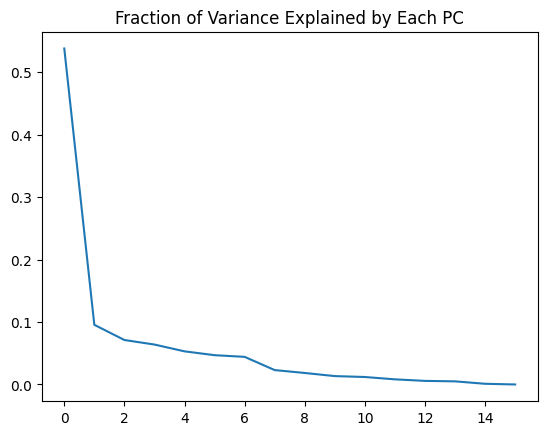

In [133]:
# Print variance expained and componenets of first PCs
plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_))
plt.title('Fraction of Variance Explained by Each PC')
keys = list(new_data.keys())
for i in range(6):
    print('PC ' + str(i))
    pc = pca.components_[i, :]
    for j in range(len(pc)):
        print(keys[j] + ': ' + str(pc[j]))
    

# Clustering

In [130]:
# cluster with, k-means, knn, optics, birch, dbscan look here for use cases https://scikit-learn.org/stable/modules/clustering.html
pca.explained_variance_/np.sum(pca.explained_variance_)

array([5.38103845e-01, 9.55576175e-02, 7.12221254e-02, 6.39474574e-02,
       5.30656558e-02, 4.69126097e-02, 4.42409676e-02, 2.30481910e-02,
       1.84248691e-02, 1.34172713e-02, 1.19733144e-02, 8.22157266e-03,
       5.74883200e-03, 5.00393418e-03, 1.11173668e-03, 4.58353251e-30])